In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)

Here we'll perform PCA to define what data configuration we're going to take into work, deal with otliers and scale data. Then we'll get to modelling.

In [4]:
# df = pd.read_csv('../data/Features_For_Traditional_ML_Techniques_v3_1.csv')
df = pd.read_parquet('../data/dataset.parquet')

In [5]:
df.head(1)

,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,BotScore,BotScoreBinary,...,PRODUCT_percentage,EVENT_percentage,WORK_OF_ART_percentage,QUANTITY_percentage,LOC_percentage,PERCENT_percentage,LANGUAGE_percentage,TIME_percentage,PERSON_percentage,total_engagement
0,End of eviction moratorium means millions of A...,1,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262,3619,34945,16423,44,0.03,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.785714,0.265026


In [6]:
df.shape
df.info()

(134198, 62)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 62 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   statement               134198 non-null  object 
 1   BinaryNumTarget         134198 non-null  int8   
 2   tweet                   134198 non-null  object 
 3   followers_count         134198 non-null  int64  
 4   friends_count           134198 non-null  int32  
 5   favourites_count        134198 non-null  int32  
 6   statuses_count          134198 non-null  int32  
 7   listed_count            134198 non-null  int32  
 8   BotScore                134198 non-null  float32
 9   BotScoreBinary          134198 non-null  int8   
 10  cred                    134198 non-null  float32
 11  normalize_influence     134198 non-null  float32
 12  mentions                134198 non-null  int16  
 13  quotes                  134198 non-null  int16  
 14  replies             

# PCA 1

### Small side step

We want to try to engineer that engagement feature we had made in the previous step but with PCA. And compare the performance.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. select the engagement features we wanna have:
engagement_features = ['replies', 'retweets', 'favourites', 'quotes']
activity_features = ['followers_count', 'listed_count']

# now log-transform and scale the features
X_ef, X_ac = np.log1p(df[engagement_features]), np.log1p(df[activity_features])
X_ef_scaled = StandardScaler().fit_transform(X_ef)
X_ac_scaled = StandardScaler().fit_transform(X_ac)

In [8]:
# 2. then we apply PCA
pca = PCA(n_components=1)  # we need only one PC for our engagement score

engagement_pca = pca.fit_transform(X_ef_scaled)
activity_pca = pca.fit_transform(X_ac_scaled)

In [9]:
# 3. add pca engagement to dataset

df['total_engagement_pca'] = engagement_pca
df['activity_pca'] = activity_pca

For further we'll create a copy of dataset, to ease the rollback if needed.

In [10]:
dfx = df.copy()
dfx.drop(columns=['statement', 'tweet', 'short_word_freq', 'long_word_freq', 'replies', 'retweets', 'quotes', 'favourites', 'total_engagement', 'BotScore', 'listed_count', 'followers_count'], inplace=True)

# Outliers

In fact that does not give much result

In [11]:
from scipy.stats.mstats import winsorize

# # Applying winsorization to each feature
def winsorize_data(series, limits=[0.01, 0.00001]):
    return winsorize(series, limits=limits)

dfx = dfx.apply(winsorize_data)

# PCA 2

### Standardize the data

In [12]:
# 1.
scaler = StandardScaler()
dfx_standardized = scaler.fit_transform(dfx)

### PCA

In [13]:
# 2.
pca = PCA()
pca.fit(dfx_standardized)

# pca = PCA()
# reduced_data_pca = pca.fit_transform(dfx_standardized)

PCA()

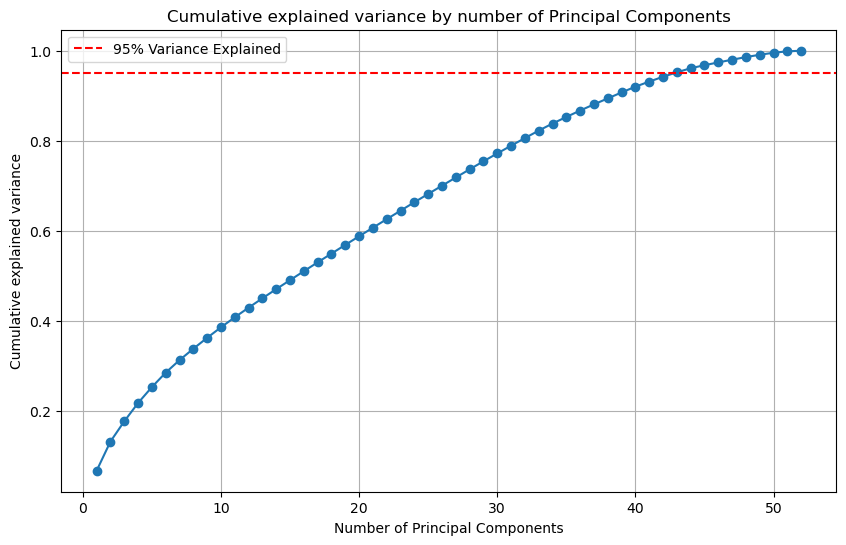

In [14]:
# 3. Plot cumulative explained variance to see the number of PCs that explain a desired level (95% in the case) of variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance by number of Principal Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.legend(loc='best')
plt.show();

The plot shows that about 40% of variance is exlained with aboutt 10 PCs, 45-47 PCs explain 95% of variance. So we can aim at that number of PCs.

Now we'll see what variance is explaind with each component with scree plot

In [15]:
# the num of picked PCs
pcs = 43

In [16]:
# 4. compute loadings
loadings = pca.components_[:pcs]

# 5. Compute the importance scores for each var
importance_scores = np.sum(np.abs(loadings), axis=0)

# 6. Create a df for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': dfx.columns,
    'Importance': importance_scores
})

# Sort featres by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top features
selected_features = feature_importance_df['Feature']

Selecting what features to pick

In [17]:
# Create a new df with the selected vars
df_selected = dfx[selected_features]
df_selected.shape
df_selected.info()

(134198, 52)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BinaryNumTarget         134198 non-null  int8   
 1   BotScoreBinary          134198 non-null  int8   
 2   adjectives              134198 non-null  int16  
 3   CARDINAL_percentage     134198 non-null  float32
 4   exclamation             134198 non-null  int16  
 5   ORDINAL_percentage      134198 non-null  float32
 6   MONEY_percentage        134198 non-null  float32
 7   LAW_percentage          134198 non-null  float32
 8   NORP_percentage         134198 non-null  float32
 9   PERSON_percentage       134198 non-null  float32
 10  DATE_percentage         134198 non-null  float32
 11  questions               134198 non-null  int16  
 12  ORG_percentage          134198 non-null  float32
 13  friends_count           134198 non-null  int32  
 14  WORK_OF_ART_percenta

From this table we see that the total_engagement_pca is ranked as more important than our total_engagement

In [18]:
# Here we drop doubling features

# df_reduced = df_selected.drop(columns=['short_word_freq', 'long_word_freq', 'replies', 'retweets', 'quotes', 'favourites', 'total_engagement', 'BotScore', 'listed_count', 'followers_count', 'listed_count'])
# df_reduced = df_selected.drop(columns=['short_word_freq', 'long_word_freq', 'replies', 'retweets', 'quotes', 'favourites', 'total_engagement', 'BotScore', 'listed_count', 'followers_count', 'listed_count', 'ampersand', 'hashtags', 'normalize_influence', 'BotScore', 'Average word length', 'BotScoreBinary', 'total_count', 'Word count'])
df_reduced = df_selected.copy()
df_reduced.shape

(134198, 52)

# Split and Scale

## Splitting

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df_reduced.drop(columns=['BinaryNumTarget'], axis=1)
y = df_reduced['BinaryNumTarget']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## Scaling

In [21]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler(unit_variance=True)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [22]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model evaluation function

In [23]:
# Function for model evaluation

from sklearn.metrics import accuracy_score, classification_report
def get_scores(model):

    if hasattr(model, 'predict_proba'):
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    else: # that's for DNN and like that
        y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
        y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

    train_accuracy = round(accuracy_score(y_train, y_train_pred),4)
    test_accuracy = round(accuracy_score(y_test, y_test_pred),4)

    print(f'Train accuracy = {train_accuracy}')
    print(f'Test accuracy = {test_accuracy}')
    print(classification_report(y_test, y_test_pred))

    tabula['Model'].append(type(model).__name__)
    tabula['Train accuracy'].append(train_accuracy)
    tabula['Test accuracy'].append(test_accuracy)

    return train_accuracy, test_accuracy

tabula = {
    'Model': [],
    'Train accuracy': [],
    'Test accuracy': []
}

# Modelling

## Logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
logreg_model = LogisticRegression(penalty='l2', C=0.1, tol=0.0001, max_iter=100).fit(X_train, y_train)

get_scores(logreg_model)

Train accuracy = 0.6552
Test accuracy = 0.6491
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     13023
           1       0.66      0.65      0.65     13817

    accuracy                           0.65     26840
   macro avg       0.65      0.65      0.65     26840
weighted avg       0.65      0.65      0.65     26840



(0.6552, 0.6491)

Before we dropped some variables our accuracy score was same -- 0.65 Train and Test. Now after dropping it is the same, so we can say that the feature engineering was good. Difference between datasets with total_engagement and dataset with total_engagement_pca instead is around 3rd digit after point. So, neglectable.

If we remove a larger number of features going from bottom to top and leaving only 45, the accuracy drops by just 0.01 point, which is also acceptable. But it does not make a significant change, so we'll stick to the initial number of features.

## SVM

In [26]:
from sklearn.svm import SVC

In [27]:
svm_rbf = SVC(kernel='rbf', C=3, gamma='auto', random_state=17).fit(X_train, y_train)

get_scores(svm_rbf)

Train accuracy = 0.798
Test accuracy = 0.7179
              precision    recall  f1-score   support

           0       0.70      0.75      0.72     13023
           1       0.74      0.69      0.72     13817

    accuracy                           0.72     26840
   macro avg       0.72      0.72      0.72     26840
weighted avg       0.72      0.72      0.72     26840



(0.798, 0.7179)

In [28]:
svm_poly = SVC(kernel='poly', C=3, gamma='auto', random_state=17).fit(X_train, y_train)

get_scores(svm_poly)

Train accuracy = 0.77
Test accuracy = 0.6974
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     13023
           1       0.72      0.68      0.70     13817

    accuracy                           0.70     26840
   macro avg       0.70      0.70      0.70     26840
weighted avg       0.70      0.70      0.70     26840



(0.77, 0.6974)

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
# bootstrap= True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators = 500
rfc = RandomForestClassifier(max_depth=12, n_estimators = 30, min_samples_leaf=1, min_samples_split=12).fit(X_train, y_train)

get_scores(rfc)

Train accuracy = 0.748
Test accuracy = 0.6801
              precision    recall  f1-score   support

           0       0.66      0.71      0.68     13023
           1       0.70      0.66      0.68     13817

    accuracy                           0.68     26840
   macro avg       0.68      0.68      0.68     26840
weighted avg       0.68      0.68      0.68     26840



(0.748, 0.6801)

## Gradient Descent Boost

In [31]:
from xgboost import XGBClassifier

In [32]:
boosted_tree_model = XGBClassifier(max_depth=7, max_leaves=40, n_estimators=900, learning_rate=0.1).fit(X_train, y_train)

get_scores(boosted_tree_model)

Train accuracy = 0.836
Test accuracy = 0.7336
              precision    recall  f1-score   support

           0       0.72      0.75      0.73     13023
           1       0.75      0.72      0.74     13817

    accuracy                           0.73     26840
   macro avg       0.73      0.73      0.73     26840
weighted avg       0.73      0.73      0.73     26840



(0.836, 0.7336)

## DNN

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks

In [34]:
dnn_model = models.Sequential()

dnn_model = models.Sequential()
dnn_model.add(layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
dnn_model.add(layers.Dense(220, activation='relu'))
dnn_model.add(layers.Dense(200, activation='selu'))
dnn_model.add(layers.Dense(200, activation='selu'))
dnn_model.add(layers.Dense(200, activation='selu'))
dnn_model.add(layers.Dense(100, activation='selu'))
dnn_model.add(layers.Dense(80, activation='selu'))
dnn_model.add(layers.Dense(units=1, activation='sigmoid'))

dnn_model.compile(optimizer=optimizers.legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [35]:
history = dnn_model.fit(X_train, y_train, epochs=550, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/550


2024-06-27 12:46:56.180364: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3355/3355 [==============================] - 5s 1ms/step - loss: 0.6166 - accuracy: 0.6588 - val_loss: 0.5849 - val_accuracy: 0.6845
Epoch 2/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5808 - accuracy: 0.6932 - val_loss: 0.5833 - val_accuracy: 0.6870
Epoch 3/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5673 - accuracy: 0.7040 - val_loss: 0.5718 - val_accuracy: 0.6936
Epoch 4/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5579 - accuracy: 0.7102 - val_loss: 0.5685 - val_accuracy: 0.6980
Epoch 5/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5501 - accuracy: 0.7152 - val_loss: 0.5672 - val_accuracy: 0.7032
Epoch 6/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5424 - accuracy: 0.7199 - val_loss: 0.5676 - val_accuracy: 0.7007
Epoch 7/550
3355/3355 [==============================] - 4s 1ms/step - loss: 0.5354 - accuracy: 0.7263 - val_loss: 0.5589 - val_accuracy: 0.70

In [36]:
get_scores(dnn_model)

839/839 [==============================] - 0s 420us/step
Train accuracy = 0.7382
Test accuracy = 0.7058
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     13023
           1       0.71      0.72      0.72     13817

    accuracy                           0.71     26840
   macro avg       0.71      0.71      0.71     26840
weighted avg       0.71      0.71      0.71     26840



(0.7382, 0.7058)

# Results

In [37]:
tabula_df = pd.DataFrame(tabula)
tabula_df

,Model,Train accuracy,Test accuracy
0,LogisticRegression,0.6552,0.6491
1,SVC,0.7980,0.7179
2,SVC,0.7700,0.6974
3,RandomForestClassifier,0.7480,0.6801
4,XGBClassifier,0.8360,0.7336
5,Sequential,0.7382,0.7058
